In [128]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Color Distribution

In [129]:
from astropy.table import Table
t_1 = Table.read('../data/sample_1_g_minus_r.dat', format='ascii')
t_2 = Table.read('../data/sample_2_g_minus_r.dat', format='ascii')
t_3 = Table.read('../data/sample_3_g_minus_r.dat', format='ascii')
t_4 = Table.read('../data/sample_4_g_minus_r.dat', format='ascii')
t_5 = Table.read('../data/sample_5_g_minus_r.dat', format='ascii')
t_6 = Table.read('../data/sample_6_g_minus_r.dat', format='ascii')
t_7 = Table.read('../data/sample_7_g_minus_r.dat', format='ascii')
t_8 = Table.read('../data/sample_8_g_minus_r.dat', format='ascii')
t_9 = Table.read('../data/sample_9_g_minus_r.dat', format='ascii')
t_10 = Table.read('../data/sample_10_g_minus_r.dat', format='ascii')
t_11 = Table.read('../data/sample_11_g_minus_r.dat', format='ascii')
t_12 = Table.read('../data/sample_12_g_minus_r.dat', format='ascii')
t_13 = Table.read('../data/sample_13_g_minus_r.dat', format='ascii')
t_14 = Table.read('../data/sample_14_g_minus_r.dat', format='ascii')
t_15 = Table.read('../data/sample_15_g_minus_r.dat', format='ascii')

# magnitude bins
mag_bins = np.arange(-24, -16.99, 0.25)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
N_mag_bins = len(mag_bins)-1

print("number of magnitude bins: ", N_mag_bins)

# color bins
color_bins = np.arange(0,1.5001,0.05)
color_bin_centers = (color_bins[:-1]+color_bins[1:])/2.0

number of magnitude bins:  28


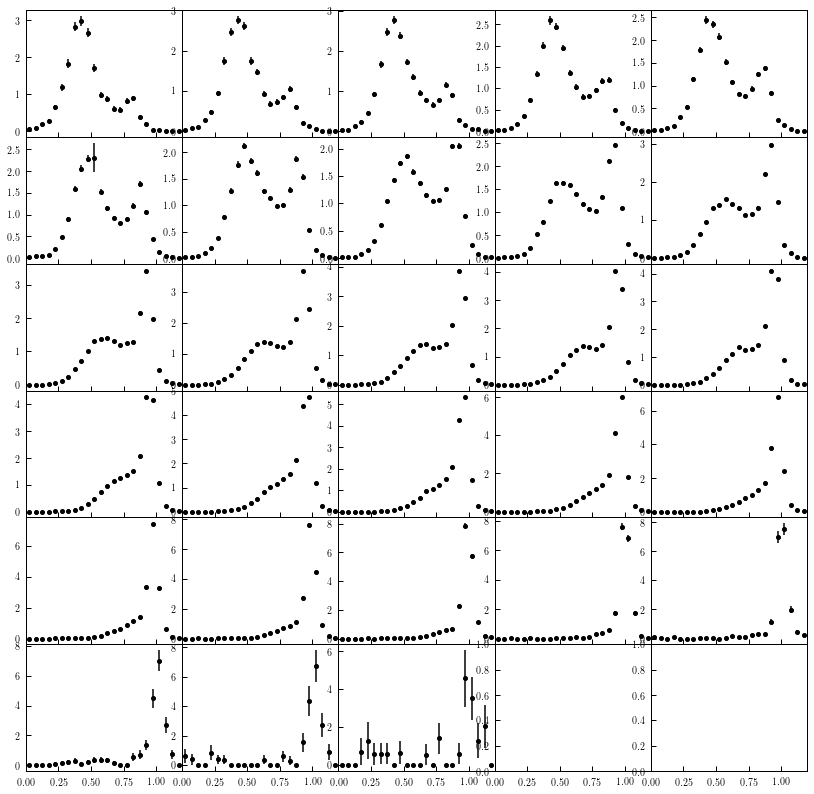

In [130]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(0,28):
    
    ax = axes[i]
    
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')
    
    x0 = t['g_minus_r']
    y0 = t['frequency']
    y0_err = t['err']
    ax.errorbar(x0,y0,y0_err,fmt='o', ms=4, color='black')
ax.set_xlim([0,1.2])   
plt.show()

# fit double gaussian model

In [131]:
from scipy.stats import norm, exponnorm
from scipy.optimize import leastsq, minimize, curve_fit

def model_pdf_1(x, loc, scale):
    """
    late type model
    """
    k = 1.0/(scale*7.1765)
    return exponnorm.pdf(x, k, loc, scale)

def model_pdf_2(x, loc, scale):
    """
    early type model
    """
    return norm.pdf(x, loc, scale)

def total_pdf(x, loc1, scale1, loc2, scale2, f):
    """
    """
    return f*model_pdf_1(x, loc1, scale1) +\
           (1.0-f)*model_pdf_2(x, loc2, scale2)

def chi_2(theta, x, y, yerr):
    """
    """
    y_model = total_pdf(x, *theta)
    
    mask = yerr>0.0
    
    d = ((y-y_model)/yerr)**2
    return np.sum(d[mask])

bounds = ([0,1],[0.01,0.2],[0.5,1.5],[0.01,0.2],[0,1])

/Users/duncan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/duncan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


(0.0, 1.2)

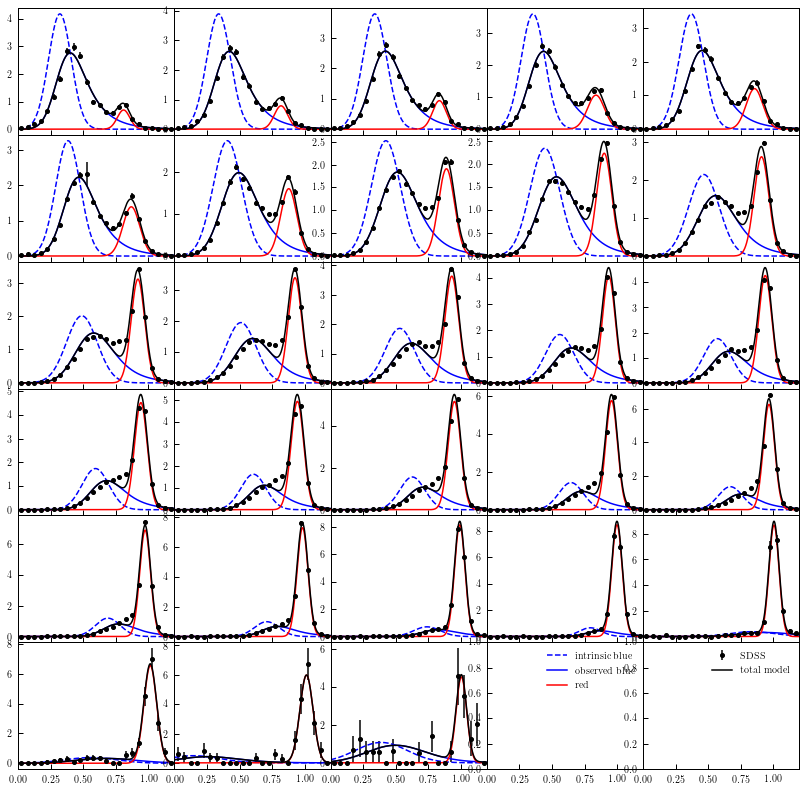

In [132]:
from galaxy_shapes.shape_models.color_model_components import GalaxyColor, BinaryGalaxyColor
color_model = GalaxyColor()
blue_fraction = BinaryGalaxyColor()
blue_fraction = blue_fraction.blue_fraction

# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

x_sample = np.linspace(0,1.5,1000)

N = len(mag_bin_centers)
m1s = np.zeros(N)
m2s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
fs = np.zeros(N)

ferrs = np.zeros(N)
m1errs = np.zeros(N)
m2errs = np.zeros(N)
s1errs = np.zeros(N)
s2errs = np.zeros(N)

for i, mag in enumerate(mag_bin_centers):
    
    m1 = color_model.lt_mean_color(mag)
    m2 = color_model.et_mean_color(mag)
    s1 = color_model.lt_scatter_color(mag)
    s2 = color_model.et_scatter_color(mag)
    f = blue_fraction(mag)
    theta0 = [m1, s1, m2, s2, f]
   
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')

    x = t['g_minus_r']
    y = t['frequency']
    yerr = t['err']
    
    res = minimize(chi_2, theta0, args=(x, y, yerr), bounds=bounds)
    theta = res.x
    
    ax = axes[i]
    
    p1 = ax.errorbar(x,y,yerr,fmt='o', ms=4, color='black')
    
    f = theta[4]
    
    m1 = theta[0]
    s1 = theta[1]
    k = 1.0/(s1*7.1765)
    l2, = ax.plot(x_sample, f*exponnorm.pdf(x_sample, k, m1, s1), color='blue')
    l3, = ax.plot(x_sample, f*norm.pdf(x_sample, m1, s1), '--', color='blue')
    
    m2 = theta[2]
    s2 = theta[3]
    l4, = ax.plot(x_sample, (1.0-f)*norm.pdf(x_sample, m2, s2), color='red')
    
    l1, = ax.plot(x_sample, f*exponnorm.pdf(x_sample, k, m1, s1) + (1.0-f)*norm.pdf(x_sample, m2, s2), color='black')
    
    fs[i] = f
    m1s[i] = m1
    m2s[i] = m2
    s1s[i] = s1
    s2s[i] = s2 
    
    mask = (yerr==0)
    yerr[mask] = 0.001
    
    theta0 = [m1, s1, m2, s2, f]
    res = curve_fit(total_pdf, x, y, p0=theta0, sigma=yerr)
    pcov = res[1]
    perr = np.sqrt(np.diag(pcov))
    
    ferrs[i] = perr[4] 
    
    m1errs[i] = perr[0] 
    m2errs[i] = perr[2] 
    
    s1errs[i] = perr[1] 
    s2errs[i] = perr[3] 

ax = axes[-2]
ax.legend([l3,l2,l4],['intrinsic blue','observed blue','red'], frameon=False)
    
ax = axes[-1]
ax.legend([p1, l1],['SDSS','total model'], frameon=False)

#ax.set_yscale('log')
#ax.set_ylim([0.01,5])

ax.set_xlim([0.0,1.2])

#fig.savefig('./figures/color_dist_fit_2.pdf',dpi=250)

(-2, 2)

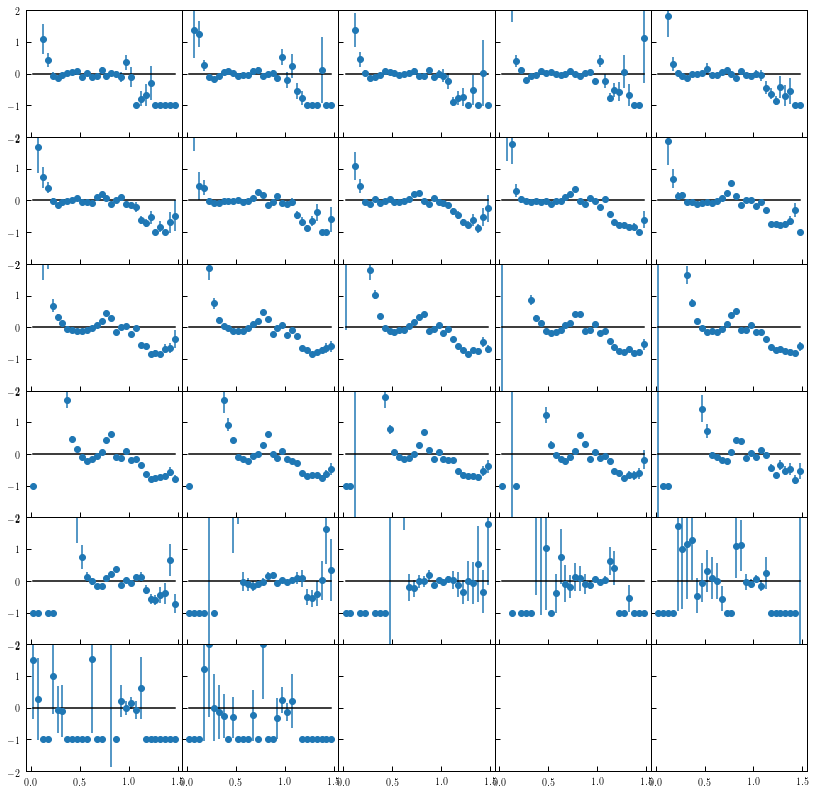

In [133]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

for i, mag in enumerate(mag_bin_centers):
    
    m1 = color_model.lt_mean_color(mag)
    m2 = color_model.et_mean_color(mag)
    s1 = color_model.lt_scatter_color(mag)
    s2 = color_model.et_scatter_color(mag)
    f = blue_fraction(mag)
    theta0 = [m1, s1, m2, s2, f]
   
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')

    x = t['g_minus_r']
    y = t['frequency']
    yerr = t['err']
    
    f = fs[i]
    m1 = m1s[i]
    m2 = m2s[i]
    s1 = s1s[i]
    s2 = s2s[i]
    k = 1.0/(s1*7.1765)
    
    y_model = f*exponnorm.pdf(x, k, m1, s1) + (1.0-f)*norm.pdf(x, m2, s2)
    
    ax.plot(x, x*0.0, '-', color='black')
    ax.errorbar(x, (y-y_model)/y_model, yerr/y_model, fmt='o')
    
    ax = axes[i]
    
ax.set_ylim([-2,2])   

In [134]:
theta0 = [-21.5, 1.5]
def sigmoid(x, x0=-20.36299482, k=0.62255499, ymin=0, ymax=1):
    """
    sigmoid function
    """
    height_diff = ymax-ymin
    return ymin + height_diff/(1 + np.exp(-k*(x-x0)))

theta_f = curve_fit(sigmoid, mag_bin_centers, fs, p0=theta0, sigma=ferrs)[0]

theta0 = [-0.10301, -1.37177]
def linear_model(x, m, b):
    return m*x + b
theta_m1 = curve_fit(linear_model, mag_bin_centers, m1s, p0=theta0, sigma=m1errs)[0]

theta0 = [-0.03347, 0.246085]
def linear_model(x, m, b):
    return m*x + b
theta_m2 = curve_fit(linear_model, mag_bin_centers, m2s, p0=theta0, sigma=m2errs)[0]

theta0 = [0.2,]
def const_model(x, b):
    return 0.0*x + b
theta_s1 = curve_fit(const_model, mag_bin_centers, s1s, p0=theta0, sigma=s1errs)[0]

theta0 = [-0.1,0.1]
def linear_model(x, m, b):
    return m*x + b
theta_s2 = curve_fit(linear_model, mag_bin_centers, s2s, p0=theta0, sigma=s2errs)[0]

(0, 0.2)

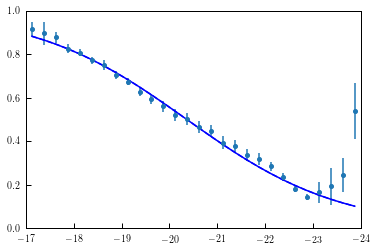

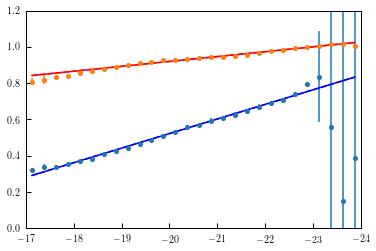

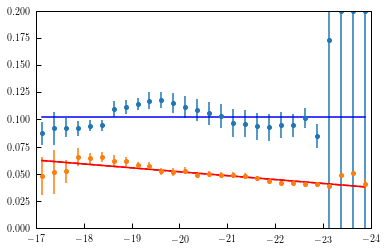

In [135]:
plt.figure()
plt.plot(mag_bin_centers, sigmoid(mag_bin_centers), '--', color='blue')
plt.plot(mag_bin_centers, sigmoid(mag_bin_centers, *theta_f), color='blue')
plt.errorbar(mag_bin_centers, fs,ferrs, fmt='o', ms=4)
plt.xlim([-17,-24])
plt.ylim([0,1])

plt.figure()
plt.plot(mag_bin_centers, color_model.lt_mean_color(mag_bin_centers), '--', color='blue')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_m1), '-', color='blue')
plt.errorbar(mag_bin_centers, m1s, m1errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, color_model.et_mean_color(mag_bin_centers), '--', color='red')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_m2), '-', color='red')
plt.errorbar(mag_bin_centers, m2s, m2errs, fmt='o', ms=4)
plt.xlim([-17,-24])
plt.ylim([0,1.2])

plt.figure()
plt.plot(mag_bin_centers, color_model.lt_scatter_color(mag_bin_centers),' --', color='blue')
plt.plot(mag_bin_centers, const_model(mag_bin_centers, *theta_s1), '-', color='blue')
plt.errorbar(mag_bin_centers, s1s, s1errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, color_model.et_scatter_color(mag_bin_centers), '--', color='red')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_s2), '-', color='red')
plt.errorbar(mag_bin_centers, s2s, s2errs, fmt='o', ms=4)
plt.xlim([-17,-24])
plt.ylim([0,0.2])

In [103]:
print(theta_m1)
print(theta_m2)

[-0.08042799 -1.08652149]
[-0.02696099  0.38073552]


In [104]:
print(theta_s1)
print(theta_s2)

[0.10226339]
[0.00359169 0.12372856]


In [105]:
print(theta_f)

[-20.36299482   0.62255499]


## three component fit

In [181]:
from scipy.stats import norm, exponnorm
from scipy.optimize import leastsq, minimize, curve_fit

def model_pdf_1(x, loc, scale):
    """
    late type model
    """
    k = 1.0/(scale*7.1765)
    return exponnorm.pdf(x, k, loc, scale)

def model_pdf_2(x, loc, scale):
    """
    early type model
    """
    return norm.pdf(x, loc, scale)

def model_pdf_3(x, loc, scale):
    """
    green valley model
    """
    return norm.pdf(x, loc, scale)

def total_pdf(x, loc1, scale1, loc2, scale2, loc3, scale3, f1, f2):
    """
    """
    p1 = f1*model_pdf_1(x, loc1, scale1) +\
           (1.0-f1)*model_pdf_2(x, loc2, scale2)
    p2 = model_pdf_3(x, loc3, scale3)
    return (1.0-f2)*p1 + f2*p2

def chi_2(theta2, x, y, yerr, theta1):
    """
    """
    loc1, scale1, loc2, scale2, f1 = theta1
    loc3, scale3, f2 = theta2
    theta = [loc1, scale1, loc2, scale2, loc3, scale3, f1, f2]
    y_model = total_pdf(x, *theta)
    
    mask = yerr>0.0
    
    d = ((y-y_model)/yerr)**2
    return np.sum(d[mask])

bounds = ([0.6, 1.0], [0.065,0.1], [0.01,0.2])

/Users/duncan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


0 [0.6        0.1        0.09480461]
1 [0.6        0.1        0.12090888]
2 [0.6        0.1        0.06252634]
3 [0.73074238 0.065      0.04790593]
4 [0.74307826 0.065      0.03141087]
5 [0.73834679 0.065      0.026066  ]
6 [0.73080148 0.065      0.0507032 ]
7 [0.77731635 0.1        0.0797168 ]
8 [0.82791127 0.1        0.08157867]
9 [0.83171996 0.1        0.11203882]
10 [0.84376721 0.1        0.11367358]
11 [0.83177154 0.1        0.12228761]
12 [0.84447157 0.1        0.12634283]
13 [0.82775408 0.1        0.1148839 ]
14 [0.79328617 0.065      0.08405258]
15 [0.80348502 0.065      0.09891809]
16 [0.82398519 0.065      0.12325049]
17 [0.83422191 0.06921195 0.13617182]
18 [0.84440097 0.06806547 0.12590593]
19 [0.8531279  0.065      0.10779899]
20 [0.85632268 0.065      0.07609192]
21 [0.8539086 0.065     0.0305252]
22 [1.    0.065 0.01 ]


(0.1, 5)

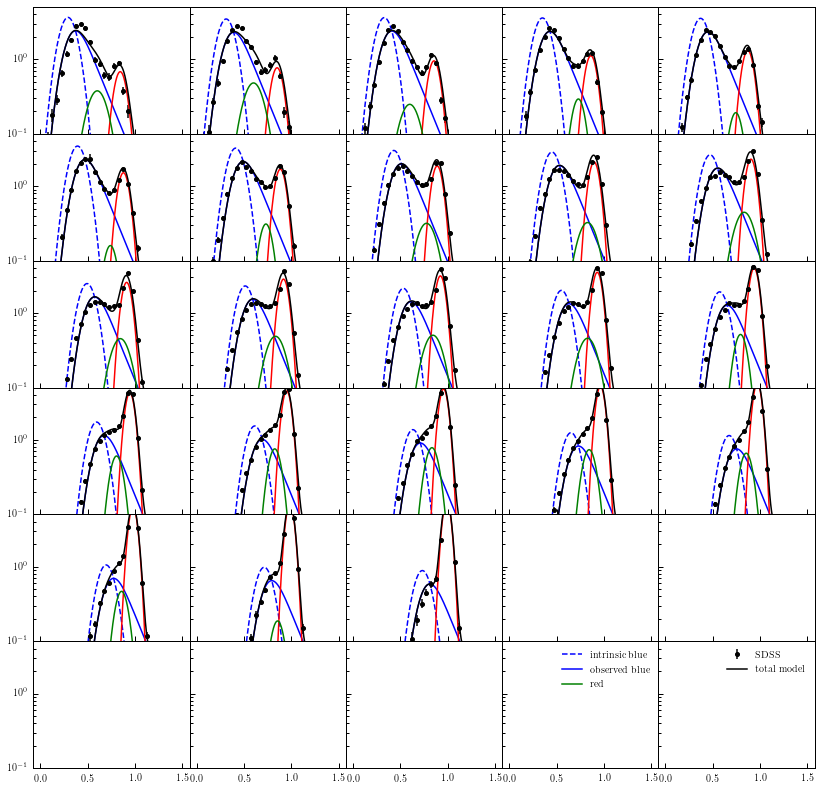

In [230]:
from galaxy_shapes.shape_models.color_model_components import GalaxyColor, BinaryGalaxyColor
color_model = GalaxyColor()
blue_fraction = BinaryGalaxyColor()
blue_fraction = blue_fraction.blue_fraction

color_model.param_dict['color_b3'] = 0.0875

# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

x_sample = np.linspace(0,1.5,1000)

N = len(mag_bin_centers)
m1s = np.zeros(N)
m2s = np.zeros(N)
m3s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
s3s = np.zeros(N)
f1s = np.zeros(N)
f2s = np.zeros(N)

f1errs = np.zeros(N)
f2errs = np.zeros(N)
m1errs = np.zeros(N)
m2errs = np.zeros(N)
m3errs = np.zeros(N)
s1errs = np.zeros(N)
s2errs = np.zeros(N)
s3errs = np.zeros(N)

for i, mag in enumerate(mag_bin_centers[:-5]):
    
    m1 = color_model.lt_mean_color(mag)
    m2 = color_model.et_mean_color(mag)
    s1 = color_model.lt_scatter_color(mag)
    s2 = color_model.et_scatter_color(mag)
    f1 = sigmoid(mag, *theta_f, ymax=1.0)
    theta1 = [m1,s1,m2,s2,f1]
    
    theta0 = [0.75, 0.085, 0.01]
   
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')

    x = t['g_minus_r']
    y = t['frequency']
    yerr = t['err']
    
    res = minimize(chi_2, theta0, args=(x, y, yerr, theta1), bounds=bounds)
    theta2 = res.x
    
    theta = [theta1[0], theta1[1],
             theta1[2], theta1[3],
             theta2[0], theta2[1],
             theta1[4], theta2[2]]
    
    ax = axes[i]
    
    p1 = ax.errorbar(x,y,yerr,fmt='o', ms=4, color='black')
    
    f1 = theta[6]
    f2 = theta[7]
    
    m1 = theta[0]
    s1 = theta[1]
    k = 1.0/(s1*7.1765)
    l2, = ax.plot(x_sample, (1-f2)*f1*exponnorm.pdf(x_sample, k, m1, s1), color='blue')
    l3, = ax.plot(x_sample, (1-f2)*f1*norm.pdf(x_sample, m1, s1), '--', color='blue')
    
    m2 = theta[2]
    s2 = theta[3]
    l4, = ax.plot(x_sample, (1-f2)*(1.0-f1)*norm.pdf(x_sample, m2, s2), color='red')
    
    m3 = theta[4]
    s3 = theta[5]
    l4, = ax.plot(x_sample, f2*norm.pdf(x_sample, m3, s3), color='green')
    
    pdf1 = (1-f2)*f1*exponnorm.pdf(x_sample, k, m1, s1)
    pdf2 = (1-f2)*(1.0-f1)*norm.pdf(x_sample, m2, s2)
    pdf3 = f2*norm.pdf(x_sample, m3, s3)
    pdf = pdf1+pdf2+pdf3
    l1, = ax.plot(x_sample, pdf, color='black')
    
    print(i, theta2)
    
    f1s[i] = f1
    f2s[i] = f2
    m1s[i] = m1
    m2s[i] = m2
    m3s[i] = m3
    s1s[i] = s1
    s2s[i] = s2 
    s3s[i] = s3
    
    mask = (yerr==0)
    yerr[mask] = 0.001
    
    theta0 = [m1, s1, m2, s2, m3, s3, f1, f2]
    res = curve_fit(total_pdf, x, y, p0=theta0, sigma=yerr)
    pcov = res[1]
    perr = np.sqrt(np.diag(pcov))
    
    f1errs[i] = perr[6] 
    f2errs[i] = perr[7] 
    
    m1errs[i] = perr[0] 
    m2errs[i] = perr[2] 
    m3errs[i] = perr[4] 
    
    s1errs[i] = perr[1] 
    s2errs[i] = perr[3] 
    s3errs[i] = perr[5] 

ax = axes[-2]
ax.legend([l3,l2,l4],['intrinsic blue','observed blue','red'], frameon=False)
    
ax = axes[-1]
ax.legend([p1, l1],['SDSS','total model'], frameon=False)

ax.set_yscale('log')
ax.set_ylim([0.1,5])

#fig.savefig('./figures/color_dist_fit_2.pdf',dpi=250)

In [231]:
theta0 = [-0.10301, -1.37177]

mask = np.array([False]*len(mag_bin_centers))
mask[11:23] = True

def linear_model(x, m, b):
    return m*x + b
theta_m3 = curve_fit(linear_model, mag_bin_centers[mask], m3s[mask], p0=theta0, sigma=m3errs[mask])[0]

theta0 = [-22.2,5.5, 0.1]
def sigmoid(x, x0=-22.25, k=5.5, ymax=0.125, ymin=0):
    """
    sigmoid function
    """
    height_diff = ymax-ymin
    return ymin + height_diff/(1 + np.exp(-k*(x-x0)))

theta_f2 = curve_fit(sigmoid, mag_bin_centers[mask], f2s[mask], p0=theta0, sigma=f2errs[mask])[0]
print(theta_f2)

[-22.2166054    6.97800719   0.11840537]


(0, 0.2)

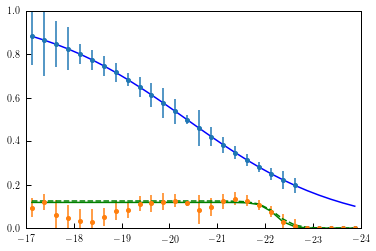

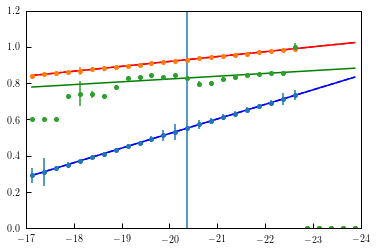

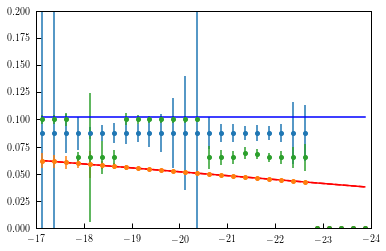

In [232]:
plt.figure()
#plt.plot(mag_bin_centers, sigmoid(mag_bin_centers), '--', color='blue')
plt.plot(mag_bin_centers, sigmoid(mag_bin_centers, *theta_f, ymax=1.0), color='blue')
plt.errorbar(mag_bin_centers, f1s, f1errs, fmt='o', ms=4)
plt.errorbar(mag_bin_centers, f2s, f2errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, sigmoid(mag_bin_centers, *theta_f2), color='green')
plt.plot(mag_bin_centers, sigmoid(mag_bin_centers),'--', color='green')
plt.xlim([-17,-24])
plt.ylim([0,1])

plt.figure()
plt.plot(mag_bin_centers, color_model.lt_mean_color(mag_bin_centers), '--', color='blue')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_m1), '-', color='blue')
plt.errorbar(mag_bin_centers, m1s, m1errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, color_model.et_mean_color(mag_bin_centers), '--', color='red')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_m2), '-', color='red')
plt.errorbar(mag_bin_centers, m2s, m2errs, fmt='o', ms=4)

plt.errorbar(mag_bin_centers, m3s, m3errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_m3), '-', color='green')

plt.xlim([-17,-24])
plt.ylim([0,1.2])

plt.figure()
plt.plot(mag_bin_centers, color_model.lt_scatter_color(mag_bin_centers),' --', color='blue')
plt.plot(mag_bin_centers, const_model(mag_bin_centers, *theta_s1), '-', color='blue')
plt.errorbar(mag_bin_centers, s1s, s1errs, fmt='o', ms=4)
plt.plot(mag_bin_centers, color_model.et_scatter_color(mag_bin_centers), '--', color='red')
plt.plot(mag_bin_centers, linear_model(mag_bin_centers, *theta_s2), '-', color='red')
plt.errorbar(mag_bin_centers, s2s, s2errs, fmt='o', ms=4)

plt.errorbar(mag_bin_centers, s3s, s3errs, fmt='o', ms=4)

plt.xlim([-17,-24])
plt.ylim([0,0.2])